In [1]:
#1.Preenchimento das datas
#->rodar esse trecho para que as datas sejam atualizadas na aba  "Semanal" e as credenciais configuradas
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import pandas as pd
from openpyxl import load_workbook
import olx_datalake

# Define o nome da planilha e da aba
sheet_name = 'Estudo estatístico métricas de growth'
sheet_tab_name = 'Semanal'

# Define as credenciais do Google Sheets (substitua pelo caminho para o seu arquivo de credenciais)
credentials_file = 'project-bht-e1805246c668.json'

# Autoriza a API do Google Sheets
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
gc = gspread.authorize(credentials)

# Abre a planilha e a aba
worksheet = gc.open(sheet_name).worksheet(sheet_tab_name)

# Lê os valores da primeira coluna
dates_column = worksheet.col_values(1)
# Encontra a última linha com uma data
last_date_index = len(dates_column) - 1
first_empty_index=last_date_index+2
# Obtém a última data registrada e converte para objeto datetime
last_date_str = dates_column[last_date_index]
last_date = datetime.strptime(last_date_str, '%Y-%m-%d')
print('last date:')
print(last_date)


# Define a data atual
current_date = datetime.now()

# Define o incremento para ir de uma semana
increment = timedelta(weeks=1)

# Começa a escrever uma semana após a última data registrada até que a data seja maior ou igual à data atual
while current_date >= last_date+increment:
    last_date += increment
    next_date = last_date.strftime('%Y-%m-%d')
    print('next date to be writen:')
    print(next_date)
    if current_date-last_date>=increment:
        worksheet.update_cell(first_empty_index, 1, next_date)
    first_empty_index+=1

print('Done! Pode continuar')


last date:
2023-09-11 00:00:00
next date to be writen:
2023-09-18
next date to be writen:
2023-09-25
Done! Pode continuar


In [2]:
# 2.Preenchimento das métricas de semanas fechadas até o momento
#rodar o passo anterior antes! E rodar esse pra preencher as métricas na aba semanal
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import pandas as pd
from openpyxl import load_workbook
import olx_datalake

# Define a data atual
today_date = datetime.now()


def column_index_from_string(column_str):
    """Converts a column name (e.g., 'A', 'AB', 'ZZ') to its numeric index."""
    base = ord('Z') - ord('A') + 1
    column_index = 0
    for char in column_str:
        if 'A' <= char <= 'Z':
            column_index = column_index * base + (ord(char) - ord('A') + 1)
        else:
            raise ValueError("Invalid column name: " + column_str)
    return column_index

def write_value_to_cell_on_date(value, tab_name, target_date, target_column):
    # Replace 'your_credentials.json' with the path to your Google Sheets credentials JSON file.
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('project-bht-e1805246c668.json', scope)

    # Replace 'your_spreadsheet' with the name of your Google Sheets spreadsheet.
    gc = gspread.authorize(credentials)
    worksheet = gc.open('Estudo estatístico métricas de growth').worksheet(tab_name)

    # Get all values from column A (date column)
    date_column = worksheet.col_values(1)

    # Find the row index with the matching target_date
    row_index = date_column.index(target_date) + 1

    # Convert the target_column name (e.g., 'AB') to numeric column index
    target_column_index = column_index_from_string(target_column.upper())

    # Write the value to the specified cell in the matching row and column
    worksheet.update_cell(row_index, target_column_index, value)

    print(f"Value {value} written to cell {target_date} in tab {tab_name}, row {row_index}, column {target_column}")

#Ler os valores da coluna B    
data_column = worksheet.col_values(2)
dates_column = worksheet.col_values(1)
# Encontra a última linha com uma data
last_date_index = len(dates_column) - 1
# Encontra a última linha com dados
last_data_index = len(data_column) - 1
first_empty_data=last_data_index+1 
#primeira data sem dados
start_date_str=dates_column[first_empty_data]
#ultima data sem dados
end_date_str = dates_column[last_date_index]
print('start_date:')
print(start_date_str)
print('end_date:')
print(end_date_str)
# Convertendo a data inicial e final para datetime
start_date = pd.to_datetime(start_date_str)
end_date = pd.to_datetime(end_date_str)
# Converte as datas para objetos datetime
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
# Define o intervalo de incremento (1 semana)
increment = timedelta(weeks=1)
# Roda o loop para cada semana
current_date = start_date
while current_date <= end_date and today_date>=current_date+increment:
    try:
        # Converter a data atual para string no formato 'yyyy-mm-dd'
        target_date = current_date.strftime('%Y-%m-%d')

        #conversoes necessarias:
        year_str, month_str, day_str = target_date.split('-')

        # Convert year_str and month_str to integers
        year = int(year_str)
        month = int(month_str)

        #chamada do datalake_olx
        dl = olx_datalake.DataLake()


        print("Tudo certo! Pode rodar as métricas!")

        #Leads OLX
        # Parametros da métrica:
        sheet_tab_name = 'Semanal'
        target_column = 'B'  
        metrica_name='leads'
        #query da métrica
        #where date_trunc('month',date(event_date)) =date('"""+target_date+"""')
        #as """+metrica_name+""",
        month_measure = dl.sql("""
            select 
        count(*) as """+metrica_name+""",
        date_trunc('week',real_date) as event_date
        from ods.ad_contacts as b
        where True
        and date_trunc('week',cast(array_join(array[b.year, b.month, b.day], '-') as date)) =date('"""+target_date+"""')
        and date_trunc('week',real_date) =date('"""+target_date+"""') 
        and (buyer_account_id_fk != seller_account_id_fk or buyer_account_id_fk is null or buyer_account_id_fk = -1) --excluir seller fazendo adview no seu anuncio
        and message_rank=1 --primeiro contato
        group by 2

        """)
        #medida no mês
        numeric_value = float(month_measure.iloc[0][metrica_name])
        #escrever métrica na célula
        write_value_to_cell_on_date(numeric_value, sheet_tab_name, target_date, target_column)  

        #Buyers OLX
        # Parametros da métrica:
        sheet_tab_name = 'Semanal'
        target_column = 'C'  
        metrica_name='buyers'
        #query da métrica
        #where date_trunc('month',date(event_date)) =date('"""+target_date+"""')
        #as """+metrica_name+""",
        month_measure = dl.sql("""
            select 
        count(distinct case when (b.buyer_account_id_fk is null or b.buyer_account_id_fk=-1) then id_tracker
        else cast(b.buyer_account_id_fk as varchar) end) as """+metrica_name+""",
        date_trunc('week',real_date) as event_date
        from ods.ad_contacts as b
        where True
        and date_trunc('week',cast(array_join(array[b.year, b.month, b.day], '-') as date)) =date('"""+target_date+"""')
        and date_trunc('week',real_date) =date('"""+target_date+"""') 
        and (buyer_account_id_fk != seller_account_id_fk or buyer_account_id_fk is null or buyer_account_id_fk = -1) --excluir seller fazendo adview no seu anuncio
        and message_rank=1 --primeiro contato
        group by 2

        """)
        #medida no mês
        numeric_value = float(month_measure.iloc[0][metrica_name])
        #escrever métrica na célula
        write_value_to_cell_on_date(numeric_value, sheet_tab_name, target_date, target_column)

        #Buyers ZAP+VR
        # Parametros da métrica:
        sheet_tab_name = 'Semanal'
        target_column = 'D'  
        metrica_name='buyers'
        #query da métrica
        #where date_trunc('month',date(event_date)) =date('"""+target_date+"""')
        #as """+metrica_name+""",
        month_measure = dl.sql("""
        select 
        count(distinct case when (accountid is null ) then fingerprint
        else accountid end) as """+metrica_name+""",
        date_trunc('week',dt) as event_date

        from  communication.valid_leads
        where True
        --and upper(origin) like '%ZAP%'
        and date_trunc('week',dt) =date('"""+target_date+"""')
        group by 2
        """)
        #medida no mês
        numeric_value = float(month_measure.iloc[0][metrica_name])
        #escrever métrica na célula
        write_value_to_cell_on_date(numeric_value, sheet_tab_name, target_date, target_column)


        #Leads ZAP+VR
        # Parametros da métrica:
        sheet_tab_name = 'Semanal'
        target_column = 'E'  
        metrica_name='leads'
        #query da métrica
        #where date_trunc('month',date(event_date)) =date('"""+target_date+"""')
        #as """+metrica_name+""",
        month_measure = dl.sql("""
        with
        deduplica as (
        select 
        case when (accountid is null ) then fingerprint
        else accountid end as user_id,
        listingidv4 as ad_id,
        leadtype

        from  communication.valid_leads
        where True
        --and upper(origin) like '%ZAP%'
        and date_trunc('week',dt) =date('"""+target_date+"""')
        group by 1,2,3
        )
        select
        count(*) as """+metrica_name+""",
        date_trunc('week',date('"""+target_date+"""')) as event_date

        from  deduplica
        group by 2
        """)
        #medida no mês
        numeric_value = float(month_measure.iloc[0][metrica_name])
        #escrever métrica na célula
        write_value_to_cell_on_date(numeric_value, sheet_tab_name, target_date, target_column)




        #incremento do loop:
        current_date += increment
    except Exception as e:
        # Se ocorrer um erro, imprima o erro e repita a iteração
        print(f"Erro na iteração para a data {current_date}: {str(e)}")
        continue


start_date:
2023-09-18
end_date:
2023-09-18
Tudo certo! Pode rodar as métricas!


FINISHED: 100%|██████████| 738/738 [00:10<00:00, 68.56 splits/s]


Value 11085174.0 written to cell 2023-09-18 in tab Semanal, row 225, column B


FINISHED: 100%|██████████| 1071/1071 [00:10<00:00, 101.07 splits/s]


Value 2813607.0 written to cell 2023-09-18 in tab Semanal, row 225, column C


FINISHED: 100%|██████████| 816/816 [00:06<00:00, 135.04 splits/s]


Value 640037.0 written to cell 2023-09-18 in tab Semanal, row 225, column D


FINISHED: 100%|██████████| 816/816 [00:06<00:00, 135.05 splits/s]


Value 1137456.0 written to cell 2023-09-18 in tab Semanal, row 225, column E


         Semana leads_olx buyers_olx buyers_zap_vr leads_zap_vr sessions_olx  \
0    2019-06-10  21410522    5067747         56536        56561                
1    2019-06-17  21550805    5098633         59637        59662                
2    2019-06-24  22663326    5393445         62753        62782                
3    2019-07-01  23522333    5478044         58676        58694                
4    2019-07-08  22993500    5321563         59064        59079                
..          ...       ...        ...           ...          ...          ...   
219  2023-08-21  11624707    3109389        556655      1051567     80582473   
220  2023-08-28  11228091    2847676        552561      1062670     78367266   
221  2023-09-04  10868985    2775475        480994       938286     73991648   
222  2023-09-11  11217426    2826389        635214      1132980                
223  2023-09-18  11085174    2813607        640037      1137456                

    active_users_olx sessions_zap activ

<Figure size 1000x600 with 0 Axes>

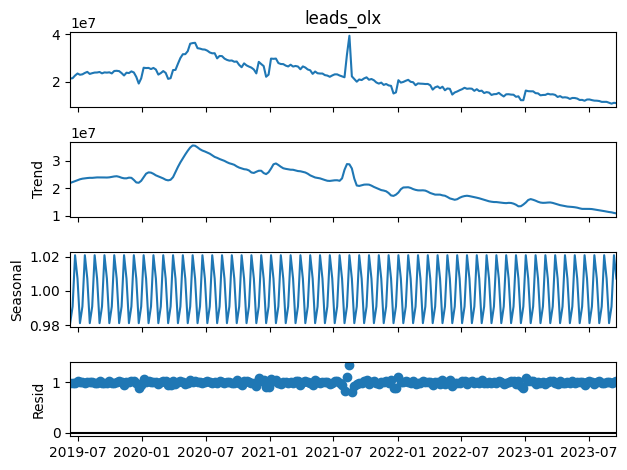

['2019-06-10', '2019-06-17', '2019-06-24', '2019-07-01', '2019-07-08', '2019-07-15', '2019-07-22', '2019-07-29', '2019-08-05', '2019-08-12', '2019-08-19', '2019-08-26', '2019-09-02', '2019-09-09', '2019-09-16', '2019-09-23', '2019-09-30', '2019-10-07', '2019-10-14', '2019-10-21', '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020

<Figure size 1000x600 with 0 Axes>

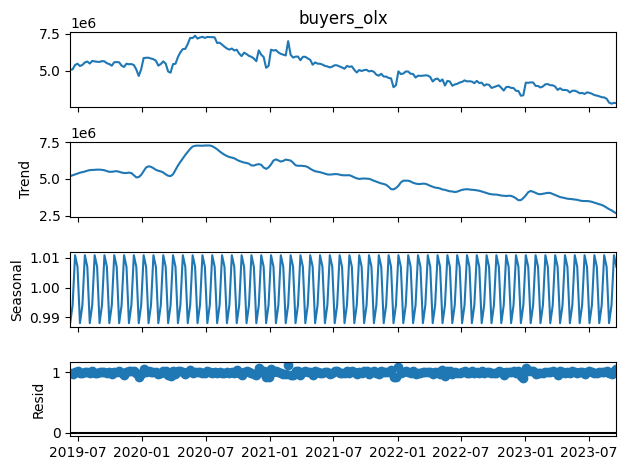

['2019-06-10', '2019-06-17', '2019-06-24', '2019-07-01', '2019-07-08', '2019-07-15', '2019-07-22', '2019-07-29', '2019-08-05', '2019-08-12', '2019-08-19', '2019-08-26', '2019-09-02', '2019-09-09', '2019-09-16', '2019-09-23', '2019-09-30', '2019-10-07', '2019-10-14', '2019-10-21', '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020

<Figure size 1000x600 with 0 Axes>

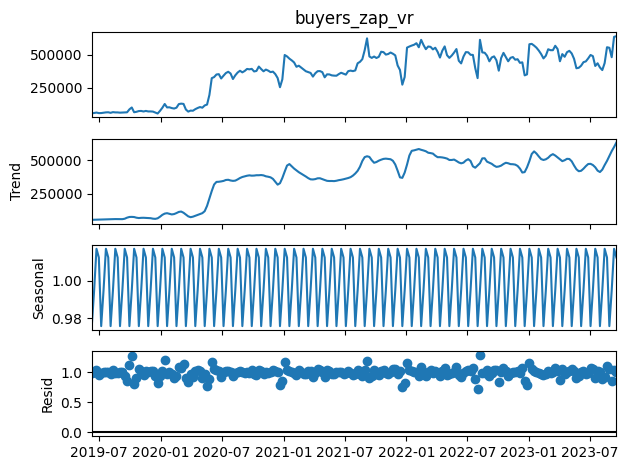

['2019-06-10', '2019-06-17', '2019-06-24', '2019-07-01', '2019-07-08', '2019-07-15', '2019-07-22', '2019-07-29', '2019-08-05', '2019-08-12', '2019-08-19', '2019-08-26', '2019-09-02', '2019-09-09', '2019-09-16', '2019-09-23', '2019-09-30', '2019-10-07', '2019-10-14', '2019-10-21', '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020

<Figure size 1000x600 with 0 Axes>

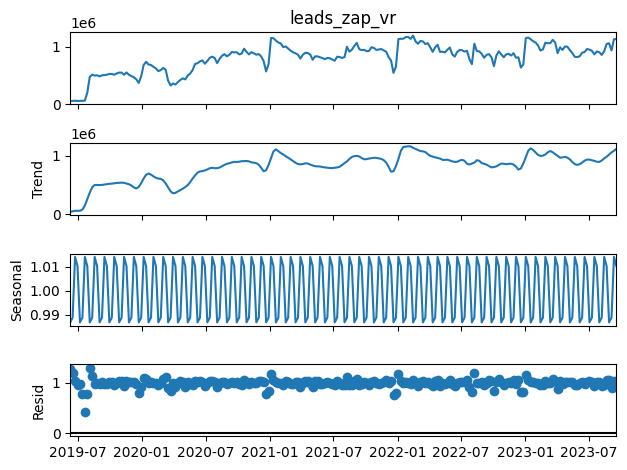

['2019-06-10', '2019-06-17', '2019-06-24', '2019-07-01', '2019-07-08', '2019-07-15', '2019-07-22', '2019-07-29', '2019-08-05', '2019-08-12', '2019-08-19', '2019-08-26', '2019-09-02', '2019-09-09', '2019-09-16', '2019-09-23', '2019-09-30', '2019-10-07', '2019-10-14', '2019-10-21', '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020

<Figure size 1000x600 with 0 Axes>

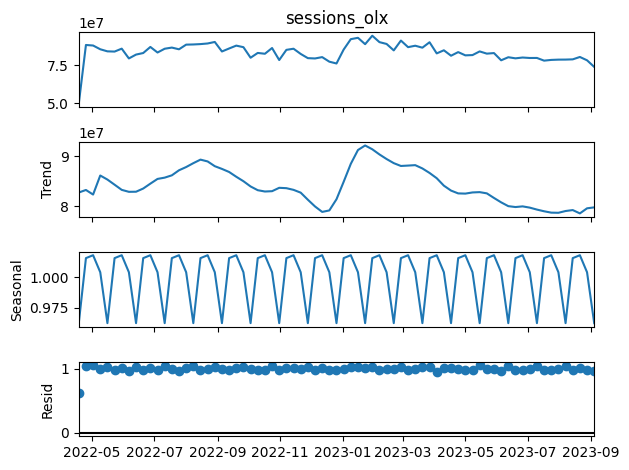

['2022-04-18', '2022-04-25', '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23', '2022-05-30', '2022-06-06', '2022-06-13', '2022-06-20', '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18', '2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023

<Figure size 1000x600 with 0 Axes>

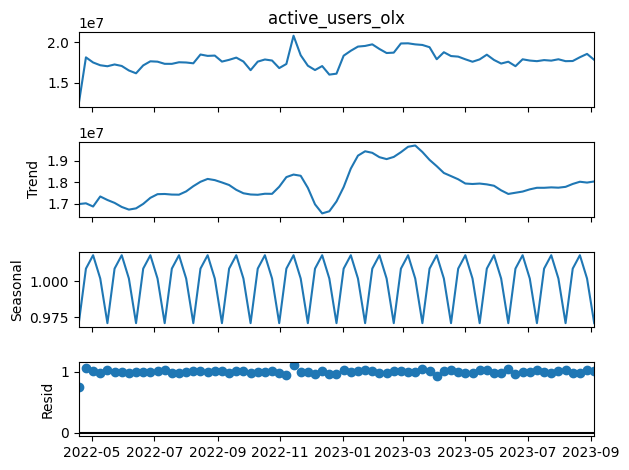

['2022-04-18', '2022-04-25', '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23', '2022-05-30', '2022-06-06', '2022-06-13', '2022-06-20', '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18', '2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023

<Figure size 1000x600 with 0 Axes>

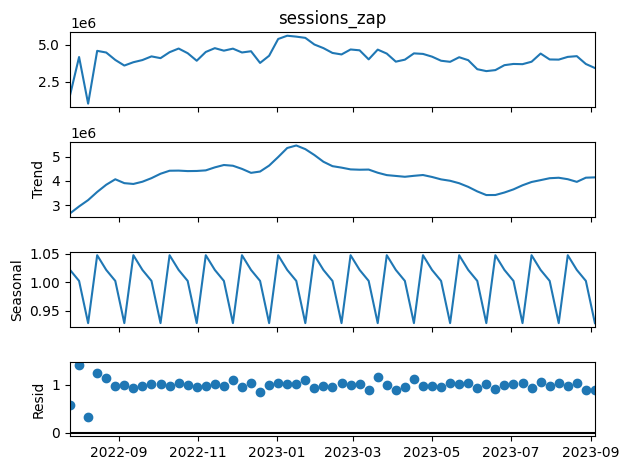

['2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04']
59
[[2651956.812499999], [2940764.687499999], [3203499.375], [3541190.0], [3839788.75], [4066659.375], [3906253.375], [3872550.125], [3965490.0], [4113372.625], [4296162.75]

<Figure size 1000x600 with 0 Axes>

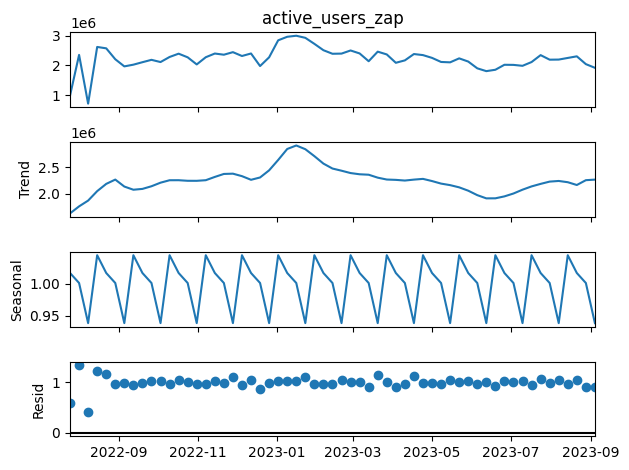

['2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04']
59
[[1622616.7375], [1756915.5625], [1867366.625], [2047933.75], [2186514.25], [2268835.875], [2135724.875], [2074813.375], [2090610.625], [2141284.625], [2209642.875], [225

<Figure size 1000x600 with 0 Axes>

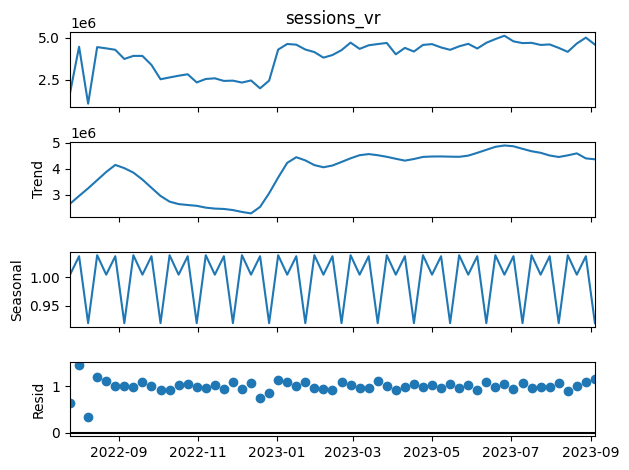

['2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04']
59
[[2658324.2124999994], [2958049.4999999995], [3249408.25], [3561456.125], [3874412.875], [4144173.625], [4021163.875], [3850435.875], [3584042.25], [3269459.75], [2958796

<Figure size 1000x600 with 0 Axes>

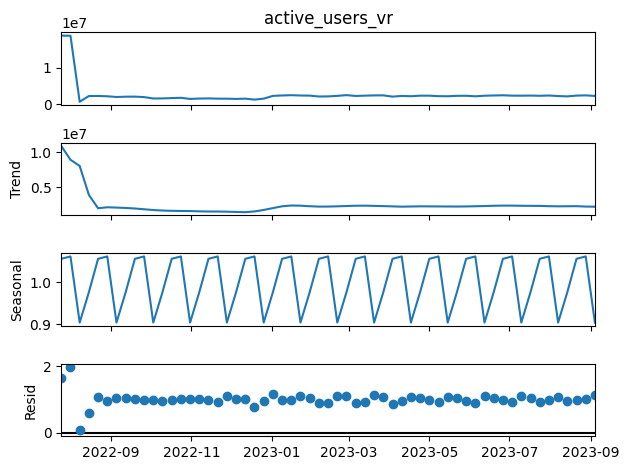

['2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04']
59
[[10870795.875000006], [8909620.937500006], [8025855.25], [3891924.125], [1984562.25], [2124392.75], [2078508.0], [2027414.0], [1948572.125], [1839044.625], [1730029.125]

In [3]:
#3.Preenchimento da decomposição das séries temporais
# rodar para preencher as demais abas com valores decompostos
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from oauth2client.service_account import ServiceAccountCredentials
import gspread

# Função para ler dados de uma planilha para um DataFrame
def read_sheet_into_dataframe(credentials_filename, sheet_name, tab_name):
    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/spreadsheets",
             "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_filename, scope)
    gc = gspread.authorize(creds)
    
    sheet = gc.open(sheet_name)
    worksheet = sheet.worksheet(tab_name)
    
    values = worksheet.get_all_values()
    
    df = pd.DataFrame(values[1:], columns=values[0])
    return df

def find_indices_first_last_non_empty(df, column_name):
    non_empty_indices = df[df[column_name] != ""].index
    first_non_empty_index = non_empty_indices[0]
    last_non_empty_index = non_empty_indices[-1]
    return first_non_empty_index, last_non_empty_index

# Informações para leitura dos dados
json_credentials_path = 'project-bht-e1805246c668.json'
sheet_name = 'Estudo estatístico métricas de growth'
sheet_tab = 'Semanal'
# Ler os dados da planilha para um DataFrame
df = read_sheet_into_dataframe(json_credentials_path, sheet_name, sheet_tab)
print(df)
#pegando nomes das colunas
column_names = df.columns.tolist()
column_names.pop(0) #tirar a coluna de semanas


for aba in column_names:

    date_col = 'Semana'  # Coluna das datas
    data_col = aba  # Coluna dos dados
    start_row, end_row = find_indices_first_last_non_empty(df, data_col)

    # Filtrar as colunas de interesse
    df_filtered = df.loc[start_row-2:end_row, [date_col, data_col]]
    print(df_filtered)

    # Converter as datas para datetime e os dados para numéricos
    df_filtered[date_col] = pd.to_datetime(df_filtered[date_col], format='%Y-%m-%d')
    df_filtered[data_col] = pd.to_numeric(df_filtered[data_col])

    # Definir a coluna de datas como índice
    df_filtered.set_index(date_col, inplace=True)

    # Realizar a decomposição para os dados filtrados
    data_series = df_filtered[data_col].dropna()
    result = seasonal_decompose(data_series, model='multiplicative', period=4, extrapolate_trend='freq')

    # Visualizar a decomposição
    plt.figure(figsize=(10, 6))
    result.plot().suptitle('', fontsize=14)
    plt.show()

    # Acesse os componentes da decomposição
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    ####################################
    # Escrita dos dados na aba sessions_olx
    new_tab_name = data_col
    gc = gspread.authorize(ServiceAccountCredentials.from_json_keyfile_name(json_credentials_path))
    new_sheet = gc.open(sheet_name).worksheet(new_tab_name)

    # Escrevendo a data
    week_dates = trend.index.strftime('%Y-%m-%d').tolist()
    print(week_dates)
    print(len(week_dates))
    data_to_update = [[date] for date in week_dates]
    new_sheet.update('B2', data_to_update)  # Week Date

    #Escrevendo a tendência
    trend_values = trend.tolist()
    trend_data_to_update = [[value] for value in trend_values]
    print(trend_data_to_update)
    print(len(trend_data_to_update))
    new_sheet.update('C2', trend_data_to_update)  

    #Escrevendo a sazonalidade
    seasonal_values = seasonal.tolist()
    seasonal_data_to_update = [[value] for value in seasonal_values]
    new_sheet.update('D2', seasonal_data_to_update)  

    #Escrevendo o residuo
    residual_values = residual.tolist()
    residual_data_to_update = [[value] for value in residual_values]
    new_sheet.update('E2', residual_data_to_update)  






 